<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/BoostedBinaryClassifers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
'=0.5.0'			 Ensembling
 analysis			 FLORES.ipynb
 Analysis			 LanguageAnalysis.ipynb
 backward_models		 language_models
 BoostedBinaryClassifers.ipynb	 LM_Thresholding.ipynb
 checkpoints			 NCD_Analysis.ipynb
 ClassificationDataset		 NNClassification.ipynb
 configs			 noisychannel
 data				 NoisyChannel.ipynb
 data-bin			 Resources
 Ensembles			 scripts
/content/drive/My Drive/Confid

In [2]:
pip install fairseq sacrebleu sentencepiece

     |████████████████████████████████| 307kB 8.2MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 1.1MB 17.2MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035408 sha256=23d3f6ad16a47a54e7b32e52cb39c0aeb0af1d1dda24a9ceead9f0845fe00def
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [3]:
# prints how much GPU RAM is available
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=28069a6ce4419609abf27dfd694da81d3de1364285aa99c5d4e92576897cb64f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


KeyboardInterrupt: ignored

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
import numpy as np
from itertools import zip_longest
from sklearn.svm import SVC


class CustomEnsembleClassifier:
    def __init__(self, clfs):
        self.classifiers = clfs
    
    def predict(self, X):
        probabilities = None
        for clf in self.classifiers:
            if probabilities is None:
                probabilities = clf.predict_proba(X)
            else:
                probabilities += clf.predict_proba(X)
        return np.argmax(np.array(probabilities), axis=1)



def printDatasetClassProp(Y): 
    classes = {}
    total = len(Y)
    for i in Y:
        if i in classes:
            classes[i] += 1
        else:
            classes[i] = 1
    
    for cls in classes:
        print("Proportion in class " + str(cls) + " = " + str(classes[cls]/total))

def datasetReader(featureFile, labelFile):
    files = [featureFile, labelFile]

    X = []
    Y = []

    for lines in zip_longest(*files, fillvalue=''):
        currX, currY = lines[0], float(lines[1].strip("\n"))
        Xarr = []
        features = currX.split()
        for feature in features:
            Xarr.append(float(feature.strip(",").strip("\n")))
        X.append(Xarr)
        Y.append(currY)
    
    return np.array(X), np.array(Y)


def computeSimilarity(o1, o2):
    total = len(o1)
    same = 0
    for i in range(len(o1)):
        if o1[i] == o2[i]:
            same += 1
    print(same/total)


def trainMLPClassifier(X, Y, verbose=True):
    if verbose:
        print("Training MLP Classifier")
    clf = MLPClassifier(hidden_layer_sizes=(30,30), random_state=1, max_iter=100)
    clf.fit(X, Y)
    return clf

def trainKNeighborsClassifier(X, Y, verbose=True):
    if verbose:
        print("Training KNeighbors Classifier")
    clf = KNeighborsClassifier(100)
    clf.fit(X, Y)
    return clf

def trainGaussianProcessClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Gaussian Process Classifier")
    length_scale = [1 for i in range(len(X[0]))]
    clf = GaussianProcessClassifier(1.0 * RBF(length_scale), warm_start=True, random_state=42, n_jobs=-1)
    clf.fit(X, Y)
    return clf

def trainCustomEnsemble(X, Y, maxDepth=8, estimators=100, verbose=True):
    if verbose:
        print("Training custom ensemble")
    rf = RandomForestClassifier(max_depth=maxDepth, random_state=42)
    grad = GradientBoostingClassifier(random_state=42)
    ada = AdaBoostClassifier(n_estimators=estimators, random_state=42)
    # dl = MLPClassifier(hidden_layer_sizes=(100), random_state=1, max_iter=200)
    # kn = KNeighborsClassifier(100)

    classifiers = [rf, grad, ada]

    for clf in classifiers:
        clf.fit(X, Y)

    return CustomEnsembleClassifier(classifiers)
    

def trainEnsembleClassifier(X, Y, maxDepth=8, estimators=100, verbose=True):
    if verbose:
        print("Training an ensemble of Random Forest and Gradient Boosting Classifiers")

    estimators = [
     ('rf', RandomForestClassifier(max_depth=maxDepth, random_state=42)),
     ('grad', GradientBoostingClassifier(random_state=42))]
    clf = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier(n_estimators=50, random_state=42))
    clf.fit(X, Y)
    return clf


def trainRandomForestClassifier(X, Y, maxDepth=8, verbose=True):
    if verbose:
        print("Training Random Forest classifier")
    clf = RandomForestClassifier(max_depth=maxDepth, random_state=42)
    clf.fit(X, Y)
    return clf

def trainAdaBoostClassifier(X, Y, estimators=100, verbose=True):
    if verbose:
        print("Training AdaBoosted Decision Tree classifier")
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=estimators, random_state=42)
    clf.fit(X, Y)
    return clf

def trainGradientBoostingClassifier(X, Y, verbose=True):
    if verbose:
        print("Training Graident Boosted classifier")
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X, Y)
    return clf

def trainSVM(X, Y, verbose=True):
    if verbose:
        print("Training SVM classifier")
    clf = SVC(gamma='auto')
    clf.fit(X, Y)
    return clf

def calculateAccuracy(predictedClasses, groundTruth):
    correct_accepted = 0
    total_accepted = 0

    correct_rejected = 0
    total_rejected = 0

    for i in range(len(predictedClasses)):
        if groundTruth[i] == 1:
            total_accepted += 1
            if predictedClasses[i] == groundTruth[i]:
                correct_accepted += 1
        else:
            total_rejected += 1
            if predictedClasses[i] == groundTruth[i]:
                correct_rejected += 1


    print("Correctly accepted = " + str(correct_accepted/total_accepted))
    print("Incorrectly rejected = " + str(1 - correct_accepted/total_accepted))
    print("Correctly rejected = " + str(correct_rejected/total_rejected))
    print("Incorrectly accepted = " + str(1 - correct_rejected/total_rejected))

    print("Total Accuracy = " + str((correct_accepted + correct_rejected)/(total_accepted + total_rejected)))

# featuresUsed = [0, 5, 6, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
# featuresUsed = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] ##All
featuresUsed = [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# featuresUsed = [10, 11, 12]


trainset = "valid"
testset = "test"
bleuThresholdTrain = 10
bleuThresholdTest = 10

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.txt")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.txt")

trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.txt")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.txt")

trainX, trainY = datasetReader(trainFeatures, trainLabels)
testX, testY = datasetReader(testFeatures, testLabels)
# print(len(trainX[0]))
# print(len(testX[0]))

print(np.array(trainX).shape)
print(np.array(testX).shape)

trainX = [[row[i] for i in featuresUsed] for row in trainX]
testX = [[row[i] for i in featuresUsed] for row in testX]

print(np.array(trainX).shape)
print(np.array(testX).shape)

printDatasetClassProp(trainY)


classifiers = [trainRandomForestClassifier, trainAdaBoostClassifier, trainGradientBoostingClassifier, trainCustomEnsemble]
outputs = []
models = []
for classifier in classifiers:
    print("#################################################")
    curr = classifier(trainX, trainY)
    predictions = np.array(curr.predict(testX))
    calculateAccuracy(predictions, testY)
    outputs.append(predictions)
    models.append(curr)
    print("#################################################")

for output_1 in outputs:
    for output_2 in outputs:
        computeSimilarity(output_1, output_2)


trainFeatures.close()
trainLabels.close()
testFeatures.close()
testLabels.close()

(2559, 22)
(2835, 22)
(2559, 19)
(2835, 19)
Proportion in class 1.0 = 0.5287221570926143
Proportion in class 0.0 = 0.4712778429073857
#################################################
Training Random Forest classifier
Correctly accepted = 0.7030965391621129
Incorrectly rejected = 0.2969034608378871
Correctly rejected = 0.7138047138047138
Incorrectly accepted = 0.2861952861952862
Total Accuracy = 0.7075837742504409
#################################################
#################################################
Training AdaBoosted Decision Tree classifier
Correctly accepted = 0.6964177292046144
Incorrectly rejected = 0.3035822707953856
Correctly rejected = 0.6759259259259259
Incorrectly accepted = 0.32407407407407407
Total Accuracy = 0.6878306878306878
#################################################
#################################################
Training Graident Boosted classifier
Correctly accepted = 0.7061323618700668
Incorrectly rejected = 0.2938676381299332
Correctly rejecte

In [0]:
class Translation:
    def __init__(self, original, reference, translation, score, category):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.category = category #0 - accepted correctly, 1 - incorrectly rejected, 2 - correctly rejected, 3 - incorrectly accepted
        self.features = []

currModel = models[0] ##Random Forest Clf
currResult = outputs[0]
groundTruth = testY
sentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")
translations = []
temp = []
index = 0
for line in sentences:
    if len(temp) < 3:
        temp.append(line)
    else:
        score = float(line.strip("\n"))
        category = 0
        if currResult[index] != groundTruth[index]:
            category = 1 if currResult[index] == 0 else 3
        else:
            category = 0 if currResult[index] == 1 else 2

        translations.append(Translation(temp[0], temp[1], temp[2], score, category))
        index += 1
        temp = []
###############verification#####################
# temp = [0 for i in range(4)]
# total = 0
# for translation in translations:
#     total += 1
#     temp[translation.category] += 1
# for i in temp:
#     print(str(float(i)/float(total)) + "\n")
###############verification#####################
labels = {0 : "Accepted Correctly", 1: "Incorrectly Rejected", 2: "Correctly Rejected", 3: "Incorrectly Accepted"}
indices = [2]

# for i in indices:
#     # print(labels[i])
#     for translation in translations:
#         if translation.category == i:
#             print(translation.reference)
#             print(translation.translation)
#             print(str(translation.score) + "\n")


totalScore = [0 for i in range(4)]
totalNum = [0 for i in range(4)]

for translation in translations:
    totalScore[translation.category] += translation.score
    totalNum[translation.category] += 1

print(np.array(totalScore)/np.array(totalNum))
sentences.close()


[22.17986025 19.1385625   8.54718777 10.39010539]


In [0]:
set1 = "valid"
set2 = "test"


set1Features = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+set1+"/features.txt")
set2Features = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+set2+"/features.txt")

set1Labels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+set1+"/result.txt")
set2Labels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+set2+"/result.txt")


_,set1Labels = datasetReader(set1Features, set1Labels)
_,set2Labels = datasetReader(set2Features, set2Labels)


num_reject = 0
for label in set1Labels:
    if label == 0:
        num_reject += 1

num_accept = 0
for label in set2Labels:
    if label == 1:
        num_accept += 1

print("Num rejected in set 1 = " + str(num_reject))
print("Num accept in set 2 = " + str(num_accept))
set1Features.close()
set2Features.close()
set1Labels.close()
set2Labels.close()

Num rejected in set 1 = 2051
Num accept in set 2 = 719


Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
Training Random Forest classifier
AUC for incuded fraction: 16.610049304594067


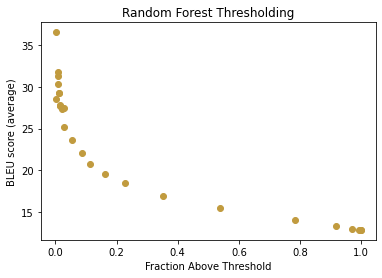

In [27]:
##make precision graphs
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")
    
    for translation in acceptedTranslations:
        temporary_reference_inclusion.write(translation.reference)
        temporary_output_inclusion.write(translation.translation)

    for translation in rejectedTranslations:
        temporary_reference_exclusion.write(translation.reference)
        temporary_output_exclusion.write(translation.translation)

    
    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        # if translation.features[0] < threshold_train:
        if translation.score < threshold_train:
            trainY.append(0)
        else:
            trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        # if translation.features[0] < threshold_train:
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

featuresUsed = [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
# featuresUsed = [0]
# featuresUsed = [0, 4]

trainset = "valid"
testset = "test"
bleuThresholdTrain = 10
bleuThresholdTest = 10

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.txt")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.txt")
trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.txt")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.txt")

trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.txt")
testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")


featuresTrain, _ = datasetReader(trainFeatures, trainLabels)
featuresTest, _ = datasetReader(testFeatures, testLabels)

featuresTrain = [[row[i] for i in featuresUsed] for row in featuresTrain]
featuresTest = [[row[i] for i in featuresUsed] for row in featuresTest]

trainTranslations = readTranslations(trainSentences, featuresTrain)
testTranslations = readTranslations(testSentences, featuresTest)

# Thresholds_train = np.linspace(-1.5, 0, 25).tolist()
Thresholds_train = np.linspace(4, 28, 25).tolist()

Thresholds_test = np.linspace(4, 28, 25).tolist()

acceptedScores = []
acceptedFraction = []

useSentenceBLEUScore = True


for index in range(len(Thresholds_test)):
    trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, Thresholds_train[index], Thresholds_test[index])

    clf = trainRandomForestClassifier(trainFeatures, trainY)
    # print("Using Average Logprob Decision Stump of " + str(Thresholds_train[index]))
    # print("BLEU score = " + str(Thresholds_test[index]))
    predictions = clf.predict(testFeatures)
    # calculateAccuracy(predictions, testY)
    # print("##########################################")
    acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
    rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
    if useSentenceBLEUScore:
        rejectedScore, acceptedScore = compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations)
    else:
        rejectedScore, acceptedScore = compute_excluded_included_score(acceptedTranslations, rejectedTranslations)
    acceptedScores.append(acceptedScore)
    acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (average)') 
plt.title('Random Forest Thresholding') 

r = random.random()
b = random.random()
g = random.random()
c = (r, g, b)
plt.scatter(acceptedFraction, acceptedScores, label = "Random Forest Analysis", color=c)

acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
acceptedFraction.sort()

print('AUC for incuded fraction: {}'.format(auc(acceptedFraction, acceptedScores)))






Experimenting with multiple parameters and plotting curves on the same graph

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random

class Translation:
    def __init__(self, original, reference, translation, score, features):
        self.original = original
        self.reference = reference
        self.translation = translation
        self.score = score
        self.features = features

def compute_exclued_included_sentenceBleuScore(acceptedTranslations, rejectedTranslations):
    acceptedScore = 0 if len(acceptedTranslations) == 0 else sum([translation.score for translation in acceptedTranslations])/len(acceptedTranslations)
    
    rejectedScore = 0 if len(rejectedTranslations) == 0 else sum([translation.score for translation in rejectedTranslations])/len(rejectedTranslations)

    return rejectedScore, acceptedScore

def compute_excluded_included_score (acceptedTranslations, rejectedTranslations):
    if len(acceptedTranslations) != 0:
        temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
        temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    
        for translation in acceptedTranslations:
            temporary_reference_inclusion.write(translation.reference)
            temporary_output_inclusion.write(translation.translation)

        temporary_reference_inclusion.close()
        temporary_output_inclusion.close()


        !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt

        temporary_inclusion_result = open("analysis/inclusion_result.txt")
        inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]

    else:
        inclusion_result_string = "0"

    if len(rejectedTranslations) != 0:

        temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
        temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")
        
        for translation in rejectedTranslations:
            temporary_reference_exclusion.write(translation.reference)
            temporary_output_exclusion.write(translation.translation)

        
        temporary_reference_exclusion.close()
        temporary_output_exclusion.close()

        !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

        temporary_exclusion_result = open("analysis/exclusion_result.txt")
        exclusion_result_string = "0" if len(rejectedTranslations) == 0 else [line for line in temporary_exclusion_result][1].split(" ")[2]
    
    else:
        exclusion_result_string = "0"

    return float(exclusion_result_string), float(inclusion_result_string)


def readTranslations(sentenceFile, featureArray):
    translations = []
    temp = []
    index = 0
    for line in sentenceFile:
        if len(temp) < 3:
            temp.append(line)
        else:
            score = float(line.strip("\n"))
            translations.append(Translation(temp[0], temp[1], temp[2], score, featureArray[index]))
            index += 1
            temp = []
    
    return translations

def getTrainTestSets(trainTranslations, testTranslations, threshold_train, threshold_test, avgLogProb):
    trainFeatures = []
    trainY = []
    testFeatures = []
    testY = []

    for translation in trainTranslations:
        trainFeatures.append(translation.features)
        if avgLogProb:
            if translation.features[0] < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
        else:
            if translation.score < threshold_train:
                trainY.append(0)
            else:
                trainY.append(1)
    
    for translation in testTranslations:
        testFeatures.append(translation.features)
        if translation.score < threshold_test:
            testY.append(0)
        else:
            testY.append(1)

    return trainFeatures, trainY, testFeatures, testY

trainset = "valid"
testset = "test"
bleuThresholdTrain = 10
bleuThresholdTest = 10

trainFeatures = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/features.txt")
testFeatures = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/features.txt")
trainLabels = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/result.txt")
testLabels = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/result.txt")


featuresTrain, _ = datasetReader(trainFeatures, trainLabels)
featuresTest, _ = datasetReader(testFeatures, testLabels)

[Random Forest Classifier] AUC for included fraction: 16.610049304594067
[Average Logprob Thresholding] AUC for included fraction: 16.027553111879268
[Sentence BLEU Thresholding] AUC for included fraction: 20.03472664187722


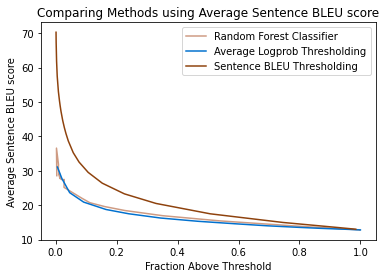

[Random Forest Classifier] AUC for included fraction: 12.068832451499118
[Average Logprob Thresholding] AUC for included fraction: 12.125724867724868
[Sentence BLEU Thresholding] AUC for included fraction: 16.301220458553793


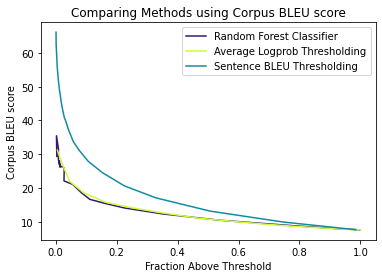

In [31]:
featuresUsed = [[0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [0], [4]]
trainThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(-1.5, -0.25, 25).tolist(), np.linspace(1, 60, 25).tolist()]
testThresholds = [np.linspace(4, 28, 25).tolist(), np.linspace(4, 28, 25).tolist(), np.linspace(1, 60, 25).tolist()]

evaluationMetrics = [compute_exclued_included_sentenceBleuScore, compute_excluded_included_score]
evalLabel = {0: "Average Sentence BLEU score", 1: "Corpus BLEU score"}
models = [trainRandomForestClassifier, trainRandomForestClassifier, trainRandomForestClassifier]
modelLabel = {0: "Random Forest Classifier", 1: "Average Logprob Thresholding", 2: "Sentence BLEU Thresholding"}
avgLogProb = [False, True, False]
acceptedScores = []
acceptedFraction = []


for evalMetric in range(len(evaluationMetrics)):
    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel(evalLabel[evalMetric]) 
    plt.title('Comparing Methods using ' + evalLabel[evalMetric])

    for model in range(len(models)):
        currFeaturesTrain = [[row[i] for i in featuresUsed[model]] for row in featuresTrain]
        currFeaturesTest = [[row[i] for i in featuresUsed[model]] for row in featuresTest]


        trainSentences = open("ClassificationDataset/"+str(bleuThresholdTrain)+"BLEU/"+trainset+"/sentences.txt")
        testSentences = open("ClassificationDataset/"+str(bleuThresholdTest)+"BLEU/"+testset+"/sentences.txt")

        trainTranslations = readTranslations(trainSentences, currFeaturesTrain)
        testTranslations = readTranslations(testSentences, currFeaturesTest)

        acceptedScores = []
        acceptedFraction = []

        for index in range(len(testThresholds[model])):
            trainFeatures, trainY, testFeatures, testY = getTrainTestSets(trainTranslations, testTranslations, trainThresholds[model][index], testThresholds[model][index], avgLogProb[model])
            clf = models[model](trainFeatures, trainY, verbose=False)
            predictions = clf.predict(testFeatures)
            
            acceptedTranslations = np.array(testTranslations)[np.array(predictions) > 0]
            rejectedTranslations = np.array(testTranslations)[np.array(predictions) < 1]
              
            rejectedScore, acceptedScore = evaluationMetrics[evalMetric](acceptedTranslations, rejectedTranslations)
            
            acceptedScores.append(acceptedScore)
            acceptedFraction.append(float(len(acceptedTranslations))/float(len(predictions)))
        
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(acceptedFraction, acceptedScores, label = modelLabel[model], color=c)
        acceptedScores = [x for _,x in sorted(zip(acceptedFraction,acceptedScores))]
        acceptedFraction.sort()

        print("["+modelLabel[model]+"] AUC for included fraction: {}".format(auc(acceptedFraction, acceptedScores)))
    plt.legend(loc="upper right")
    plt.show()

